In [2]:
# imports
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np

sys.path.append("..")
from src.utils import *
from scipy.stats import ttest_ind, permutation_test
from scipy import stats

In [3]:
# polars config
pl.Config.load_from_file("../polars_cfg.json")

In [4]:
# data file paths
summary_path = "../data/summary_data.csv"
data_path = "../data/data.csv"

In [5]:
df_summary = pl.read_csv(summary_path)
df_all = pl.read_csv(data_path)

# parse time
df_all = df_all.with_columns(pl.col("time").cast(pl.Datetime))

columns = [
    "exp_name",
    "hashed_id",
    "joint_id_task",
    "task_name",
    "task_number",
    "task_type",
    "attempt_number",
    "action",
    "action_id",
    "solved",
    "time",
    "test_input_grid",
    "test_output_grid",
]
df_all = df_all.select(columns)

# load task accuracy data
mean_task_acc = pl.read_csv("../data/mean_task_acc_three_attempts.csv")

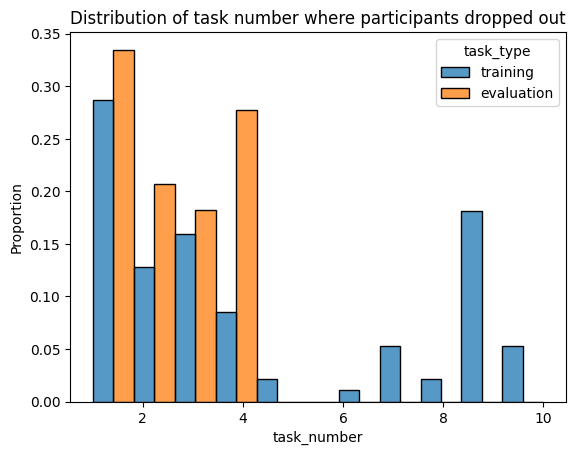

In [7]:
# plot distribution of task number where participants dropped out
sns.histplot(
    df_summary.filter(~pl.col("complete")).select(
        pl.all()
        .top_k_by("task_number", k=1)
        .over("hashed_id", mapping_strategy="explode")
    ),
    x="task_number",
    hue="task_type",
    multiple="dodge",
    stat="proportion",
    common_norm=False,
)
plt.title("Distribution of task number where participants dropped out")
plt.show()

In [8]:
# for each task_type, compute how many drop after 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 attempts
# total_training =
dropout_after = (
    df_summary.filter(~pl.col("complete"))
    .group_by("hashed_id")
    .agg(pl.max("task_number"), pl.first("task_type"))
    .group_by(["task_type", "task_number"])
    .agg(pl.len())
)
dropout_after.sort(["task_type", "task_number"]).head()

task_type,task_number,len
str,i64,u32
"""evaluation""",1,81
"""evaluation""",2,50
"""evaluation""",3,44
"""evaluation""",4,67
"""training""",1,27


In [9]:
# dropout rates
training_incomplete = (
    df_summary.filter(~pl.col("complete"))
    .filter(pl.col("task_type") == "training")
    .n_unique("hashed_id")
)
training_total = df_summary.filter(pl.col("task_type") == "training").n_unique(
    "hashed_id"
)
training_dropout_rate = training_incomplete / training_total

evaluation_incomplete = (
    df_summary.filter(~pl.col("complete"))
    .filter(pl.col("task_type") == "evaluation")
    .n_unique("hashed_id")
)
evaluation_total = df_summary.filter(pl.col("task_type") == "evaluation").n_unique(
    "hashed_id"
)
evaluation_dropout_rate = evaluation_incomplete / evaluation_total

print(
    f"Training dropout rate: {training_incomplete}/{training_total} ({training_dropout_rate:.3f}, {round(training_dropout_rate * 100, 1)}%)"
)
print(
    f"Evaluation dropout rate: {evaluation_incomplete}/{evaluation_total} ({evaluation_dropout_rate:.3f}, {round(evaluation_dropout_rate * 100, 1)}%)"
)

Training dropout rate: 94/783 (0.120, 12.0%)
Evaluation dropout rate: 242/946 (0.256, 25.6%)


In [10]:
# amount of missing data
df_summary_ten = df_summary.filter(pl.col("exp_name").is_in(["expv0", "expv1"]))
df_summary_five = df_summary.filter(~pl.col("exp_name").is_in(["expv0", "expv1"]))
total_expected_task_data = (
    df_summary_ten.n_unique("hashed_id") * 10
    + df_summary_five.n_unique("hashed_id") * 5
)
total_expected_task_data_training = (
    df_summary_ten.n_unique("hashed_id") * 10
    + df_summary_five.filter(pl.col("task_type") == "training").n_unique("hashed_id")
    * 5
)
total_expected_task_data_evaluation = (
    df_summary_five.filter(pl.col("task_type") == "evaluation").n_unique("hashed_id")
    * 5
)
observed_task_data = df_summary.n_unique("joint_id_task")
observed_task_data_training = df_summary.filter(
    pl.col("task_type") == "training"
).n_unique("joint_id_task")
observed_task_data_evaluation = df_summary.filter(
    pl.col("task_type") == "evaluation"
).n_unique("joint_id_task")
print(
    f"Proportion of task data missing: {round((1 - observed_task_data / total_expected_task_data) * 100, 1)}%"
)
print(
    f"Proportion of task data expected on training set: {round((1 - observed_task_data_training / total_expected_task_data_training) * 100, 1)}%"
)
print(
    f"Proportion of task data expected on evaluation set: {round((1 - observed_task_data_evaluation / total_expected_task_data_evaluation) * 100, 1)}%"
)

Proportion of task data missing: 10.3%
Proportion of task data expected on training set: 7.5%
Proportion of task data expected on evaluation set: 13.3%
